# Dynamic Allocation - Context Engineering

**학습 목표**:
- 동적으로 컨텍스트를 할당하는 방법을 이해합니다.
- Agent 2.0 Paradigm 을 통해 동적으로 컨텍스트를 할당합니다.
- 컨텍스트 엔지니어링을 통해 SubAgents 성능을 최적화합니다.

---

In [73]:
import ast
import operator
from collections.abc import Sequence
from dataclasses import dataclass
from pprint import pprint
from typing import Annotated, Any, Literal, TypedDict

import tiktoken
from deepagents import create_deep_agent
from dotenv import load_dotenv
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langchain.messages import AIMessage, AnyMessage, HumanMessage, SystemMessage
from langchain.tools import ToolRuntime, tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import BaseTool
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.runtime import Runtime
from langgraph.types import Command
from pydantic import BaseModel, Field

load_dotenv()

from openrouter_llm import (
    create_embedding_model,
    create_embedding_model_direct,
    create_openrouter_llm,
)

# LLM 선언
llm = create_openrouter_llm("openai/gpt-4.1-mini")
openai_embeddings = create_embedding_model("openai/text-embedding-3-small")
qwen_embeddings = create_embedding_model_direct("qwen/qwen3-embedding-0.6b")

## Agent 2.0 Paradigm - `Shallow` vs `Deep Agents`

Agent 1.0 (Shallow Agent)는 단순한 루프 구조입니다:
- 사용자 프롬프트 → LLM 도구 선택 → 실행 → 결과 반환 → 반복
- 모든 정보가 LLM의 컨텍스트 창에만 존재 (무상태성)
- 단기적, 단순한 작업(12단계 이하)에는 적합
- **한계**: 컨텍스트 창 포화, 목표 상실, 복구 불가능한 막다른 골목

Agent 2.0 (Deep Agent)는 아키텍처적 전환입니다:
- **명시적 계획**: `write_todos` 도구로 복잡한 작업을 단계별로 분해
- **영구 메모리**: 파일 시스템/데이터베이스로 컨텍스트를 외부화
- **계층적 위임**: 오케스트레이터가 전문 서브에이전트에게 작업 위임
- **고급 프롬프트**: 1000+ 토큰의 상세한 시스템 프롬프트로 행동 제어

### DeepAgent

DeepAgent 라이브러리는 Agent 2.0 패러다임을 실현하기 위한 몇가지 핵심 구성요소를 제공합니다:

#### 1. 체계적인 계획 및 작업 분해 (Explicit Planning)
- `TodoListMiddleware`가 제공하는 `write_todos` 도구
- 복잡한 목표를 달성하기 위한 구체적인 단계들을 명시적으로 나열
- LLM이 추론 과정을 구조화된 형식(To-do 리스트)으로 외부화
- 진행 상황 추적 및 동적 계획 수정 가능

#### 2. 공유 작업 공간으로서의 가상 파일 시스템 (File System)
- `FilesystemMiddleware`가 제공하는 6가지 도구: `ls`, `read_file`, `write_file`, `edit_file`, `glob`, `grep`
- 컨텍스트 창의 한계를 극복하고 장기 기억 구현
- 대규모 도구 결과를 자동으로 파일에 저장하여 컨텍스트 포화 방지
- **이중 메모리 모델**: 임시 파일(스크래치패드) vs 영구 파일(`/memories/` 경로)

#### 3. 컨텍스트 격리를 위한 서브 에이전트 위임 (Subagent Delegation)
- `SubAgentMiddleware`가 제공하는 `task` 도구
- 메인 에이전트가 전문화된 임시 서브에이전트(ephemeral subagents) 생성 및 위임
- **컨텍스트 격리(Context Quarantine)**: 서브에이전트의 중간 단계는 메인 에이전트 컨텍스트에 영향을 주지 않음
- 오케스트레이터-작업자 패턴의 구현체

### Shallow vs Deep Agent 비교

| 특성 | Shallow Agent (Agent 1.0) | Deep Agent (Agent 2.0) |
|------|---------------------------|------------------------|
| **계획** | 암묵적(implicit) Chain-of-Thought | 명시적(explicit) To-do 리스트 |
| **메모리** | 컨텍스트 창만 사용 | 파일 시스템 + 영구 저장소 |
| **작업 분해** | 단일 루프에서 모든 작업 처리 | 서브에이전트에게 위임 |
| **프롬프트** | 간단한 시스템 프롬프트 (~100 tokens) | 상세한 지침 포함 (1000+ tokens) |
| **컨텍스트 관리** | 수동 (개발자) | 자동 (미들웨어) |
| **적합한 작업** | 단기적, 단순 (12단계 이하) | 장기적, 복잡 (수백 단계, 며칠간) |

### 핵심 인사이트

**"Deep Agent의 '깊이'는 단순히 작업을 실행하는 것을 넘어, 작업 수행에 필요한 정보를 시간의 흐름에 따라 전략적으로 관리하는 능력이다."**

이것이 바로 **컨텍스트 엔지니어링**의 본질입니다. Agent 2.0 패러다임의 성공은 더 나은 알고리즘이 아니라, 정교한 컨텍스트 관리 전략에 달려 있습니다.

## Skills 번들 주입: System Prompt + Context + Tool

Anthropic Skills 아이디어를 참고해, 
각 Skill을 다음 3요소로 정의하고 DeepAgent에 `동적으로 주입`합니다.

- System Prompt: 역할/행동 지침
- Context: 운영 파라미터, 정책, 사전 지식 등
- Tools: 해당 Skill 전용 도구 집합

여러 Skill을 병합해 하나의 에이전트를 생성하는 유틸리티를 구현합니다.

참고 문서: 
- [anthropics/skills](https://github.com/anthropics/skills)
- [LangChain V1.0 ToolRuntime](https://docs.langchain.com/oss/python/langchain/tools)


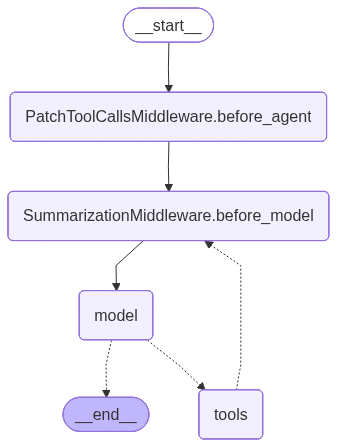

In [74]:
class Skill(TypedDict):
    name: str
    system_prompt: str  # 역할/규칙
    context: dict[str, Any]  # 정책/파라미터/사전지식
    tools: Sequence[BaseTool]  # LangChain BaseTool, @tool 데코레이터 함수 등


def _render_context_md(context: dict[str, Any]) -> str:
    if not context:
        return ""
    lines = [
        "\n## Skill Context",
        "- 이 섹션은 런타임에 주입되는 운영 파라미터/정책/사전지식입니다.",
    ]
    for k, v in context.items():
        lines.append(f"- {k}: {v}")
    return "\n".join(lines)


def compile_skills(skills: Sequence[Skill]) -> tuple[str, list[Any]]:
    """여러 Skill을 결합해 하나의 System Prompt와 Tools 묶음을 생성합니다."""
    prompt_parts = [
        "# Active Skills (System Prompt + Context + Tools)",
        "각 스킬은 역할 지침(System Prompt)과 운영 컨텍스트(Context), 전용 Tools를 포함합니다.",
    ]
    all_tools: list[Any] = []
    for s in skills:
        prompt_parts.append(f"\n---\n## Skill: {s['name']}\n\n" + s["system_prompt"])
        prompt_parts.append(_render_context_md(s["context"]))
        all_tools.extend(list(s["tools"]))
    merged_prompt = "\n\n".join(prompt_parts)
    return merged_prompt, all_tools


# 샘플 도구 구현 (데모용, 외부 시스템 없이 동작)
@tool
def reset_password(user_id: str) -> str:
    """사용자 비밀번호를 초기화하고 안내를 반환합니다."""
    return f"[mock] 사용자 {user_id}의 비밀번호를 초기화했습니다. 이메일을 확인하세요."


@tool
def search_knowledge_base(query: str) -> str:
    """내부 Knowledge Base에서 질의어로 문서를 찾고 요약을 반환합니다."""
    return f"[mock] '{query}'에 대한 관련 문서 3건을 찾았고 요약을 반환합니다."


# 예시 스킬 정의
account_recovery_skill: Skill = {
    "name": "Account Recovery",
    "system_prompt": (
        "당신은 계정 복구 전문가입니다. 신원 확인 후 비밀번호 초기화, 잠금 해제, 상태 안내를 수행합니다.\n"
        "응답 시 보안 수칙을 준수하고 민감정보를 노출하지 마세요."
    ),
    "context": {
        "id_verification": "2-step",
        "password_policy": "min_len=12, complexity=high",
    },
    "tools": [reset_password],
}

kb_search_skill: Skill = {
    "name": "KB Search",
    "system_prompt": (
        "당신은 기술문서 검색 전문가입니다. 내부 KB를 검색하고 절차형 가이드를 제공합니다.\n"
        "항상 출처/근거를 함께 제시하고 한글로 단계별 설명을 제공합니다."
    ),
    "context": {
        "ranking": "bm25",
        "max_results": 3,
    },
    "tools": [search_knowledge_base],
}

# 스킬 병합 → DeepAgent 에이전트 생성
merged_prompt, merged_tools = compile_skills([account_recovery_skill, kb_search_skill])
agent = create_deep_agent(
    model=llm,
    tools=merged_tools,
    system_prompt=merged_prompt,
)
agent

In [ ]:
# Anthropic 스타일 SKILL.md 로더 / 매퍼 / 병합 유틸리티
import re
from pathlib import Path
from typing import Any

import yaml


def load_skill_from_folder(folder: Path) -> dict:
    """SKILL.md 파일을 포함한 Skill 폴더를 로드합니다.

    Anthropic Skills 형식의 SKILL.md 파일을 파싱하여 스킬 정보를 추출합니다.
    SKILL.md는 YAML frontmatter와 마크다운 본문으로 구성되어야 합니다.

    Args:
        folder: SKILL.md 파일이 포함된 폴더 경로

    Returns:
        다음 키를 포함하는 딕셔너리:
            - name (str): 스킬 이름
            - description (str): 스킬 설명
            - allowed_tools (list): 허용된 도구 목록
            - metadata (dict): 메타데이터 (운영 파라미터, 정책 등)
            - body_md (str): 마크다운 본문 내용

    Raises:
        FileNotFoundError: SKILL.md 파일이 존재하지 않는 경우
        ValueError: YAML frontmatter가 없거나 필수 필드(name, description)가 누락된 경우

    Example:
        >>> skill = load_skill_from_folder(Path("skills/account-recovery"))
        >>> print(skill["name"])
        'account-recovery'
    """
    skill_md_path = folder / "SKILL.md"
    if not skill_md_path.exists():
        raise FileNotFoundError(f"SKILL.md 파일을 찾을 수 없습니다: {folder}")
    text = skill_md_path.read_text(encoding="utf-8")
    m = re.match(r"^---\n(.*?)\n---\n(.*)$", text, re.DOTALL)
    if not m:
        raise ValueError("SKILL.md는 YAML frontmatter(---로 구분)로 시작해야 합니다")
    frontmatter = yaml.safe_load(m.group(1)) or {}
    body_md = (m.group(2) or "").strip()

    name = frontmatter.get("name")
    description = frontmatter.get("description")
    if not name or not description:
        raise ValueError("SKILL.md에는 'name'과 'description' 필드가 필수입니다")

    allowed_tools = frontmatter.get("allowed-tools", []) or []
    metadata = frontmatter.get("metadata", {}) or {}
    return {
        "name": name,
        "description": description,
        "allowed_tools": allowed_tools,
        "metadata": metadata,
        "body_md": body_md,
    }


def map_skill_to_deepagent(skill: dict, available_tools: dict[str, Any]) -> dict:
    """로드된 스킬 사양을 DeepAgent의 프롬프트/컨텍스트/도구 번들로 매핑합니다.

    스킬 정의를 DeepAgent가 사용할 수 있는 형식으로 변환합니다.
    allowed_tools에 지정된 도구만 포함하거나, 지정이 없으면 모든 도구를 포함합니다.

    Args:
        skill: load_skill_from_folder()로 로드된 스킬 딕셔너리
        available_tools: 사용 가능한 도구들의 딕셔너리 (이름 → 도구 객체)

    Returns:
        다음 키를 포함하는 딕셔너리:
            - name (str): 스킬 이름
            - system_prompt (str): 시스템 프롬프트 (역할, 설명, 안전 규칙 포함)
            - context (dict): 스킬 메타데이터
            - tools (list): 매핑된 도구 목록

    Example:
        >>> available = {"reset_password": reset_password_tool}
        >>> mapped = map_skill_to_deepagent(skill, available)
        >>> print(mapped["name"])
        'account-recovery'
    """
    if skill["allowed_tools"]:
        tools = [available_tools[n] for n in skill["allowed_tools"] if n in available_tools]
    else:
        tools = list(available_tools.values())

    system_prompt = (
        f"## Skill: {skill['name']}\n\n"
        f"{skill['description']}\n\n"
        f"{skill['body_md']}\n\n"
        "## 안전 및 사용 규칙\n"
        "- 최소 권한 원칙 준수: 허용된 도구만 사용하세요.\n"
        "- 비밀 정보나 개인정보를 유출하지 마세요. 민감한 데이터는 가려서 표시하세요.\n"
    )
    return {
        "name": skill["name"],
        "system_prompt": system_prompt,
        "context": skill["metadata"],
        "tools": tools,
    }


def merge_skills(mapped_skills: list[dict]) -> tuple[str, list[Any], dict[str, dict]]:
    """여러 매핑된 스킬을 하나의 시스템 프롬프트와 도구 목록으로 병합합니다.

    여러 스킬의 시스템 프롬프트를 결합하고, 도구 목록을 통합하며,
    각 스킬의 컨텍스트를 보존합니다. 중복된 도구는 자동으로 제거됩니다.

    Args:
        mapped_skills: map_skill_to_deepagent()로 매핑된 스킬 딕셔너리 리스트

    Returns:
        튜플 (merged_prompt, merged_tools, merged_context_by_skill):
            - merged_prompt (str): 병합된 시스템 프롬프트
            - merged_tools (list): 중복 제거된 도구 목록
            - merged_context_by_skill (dict): 스킬 이름별 컨텍스트 딕셔너리

    Example:
        >>> mapped = [map_skill_to_deepagent(skill1, tools), map_skill_to_deepagent(skill2, tools)]
        >>> prompt, tools, contexts = merge_skills(mapped)
        >>> print(len(tools))
        5
    """
    prompt_parts: list[str] = []
    tools_accum: list[Any] = []
    ctx_by_skill: dict[str, dict] = {}

    for s in mapped_skills:
        prompt_parts.append("\n---\n" + s["system_prompt"])
        tools_accum.extend(s["tools"])
        ctx_by_skill[s["name"]] = s["context"]

    # 도구 이름으로 중복 제거
    dedup: dict[str, Any] = {}
    for t in tools_accum:
        key = getattr(t, "name", repr(t))
        dedup[key] = t

    merged_prompt = "\n".join(prompt_parts)
    return merged_prompt, list(dedup.values()), ctx_by_skill

## DeepAgent: SubAgent 활용

### 학습 목표
- 복잡한 작업을 여러 SubAgent에게 병렬로 위임하는 방법 이해
- Orchestrator-Workers 패턴 구현
- 컨텍스트 격리를 통한 효율적인 멀티 에이전트 시스템 구축

### 핵심 인사이트
**"SubAgent는 단순한 작업 분할이 아니라, 각 에이전트가 독립된 컨텍스트에서 깊이 파고들고 최종 결과만 간결하게 반환하여 메인 에이전트의 컨텍스트를 깨끗하게 유지하는 것이 목표입니다."**

In [ ]:
# SubAgent 정의: 연구 전문가
from deepagents.middleware.subagents import SubAgent

research_subagent = SubAgent(
    **{
        "name": "language-researcher",
        "description": """특정 프로그래밍 언어의 인기도, 트렌드, 사용 통계를 심층 조사합니다.
    한 번에 하나의 언어만 조사하세요. 여러 언어를 동시에 조사하지 마세요.""",
        "system_prompt": """당신은 프로그래밍 언어 트렌드 연구 전문가입니다.

주어진 프로그래밍 언어에 대해 다음을 조사하여 상세한 보고서를 작성하세요:
1. 2025년 GitHub 활동 통계
2. Stack Overflow 질문 트렌드
3. 주요 기업 채용 수요
4. 커뮤니티 활성도
5. 주요 강점과 약점

최종 보고서는 사용자가 직접 볼 수 있도록 명확하고 간결하게 작성하세요.
중간 조사 과정은 메인 에이전트에게 보이지 않으므로, 최종 메시지에 모든 핵심 내용을 포함하세요.""",
        "tools": [
            TavilySearch(max_results=5, search_depth="advanced"),
        ],
    }
)

# SubAgent 정의: 비교 분석가
analyst_subagent = SubAgent(
    **{
        "name": "comparative-analyst",
        "description": "여러 조사 결과를 비교 분석하고 인사이트를 도출합니다.",
        "system_prompt": """당신은 데이터 비교 분석 전문가입니다.

제공된 여러 조사 결과를 바탕으로:
1. 공통점과 차이점 분석
2. 각 언어의 상대적 강약점
3. 사용 사례별 권장사항
4. 미래 트렌드 예측

비교 표와 함께 명확한 결론을 제시하세요.""",
        "tools": [],
    }
)

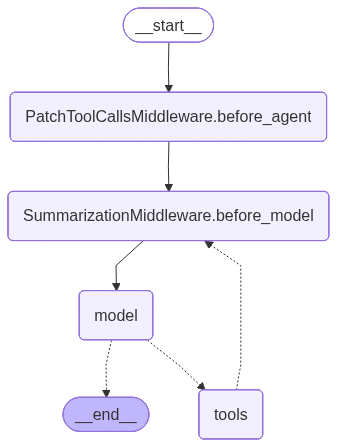

In [76]:
# Orchestrator Agent 생성
orchestrator_prompt = """당신은 프로젝트 매니저입니다. 복잡한 연구 프로젝트를 관리합니다.

## 역할
- 사용자의 요청을 분석하고 작업을 계획합니다
- 전문 SubAgent에게 작업을 위임합니다
- SubAgent의 결과를 취합하여 최종 답변을 생성합니다

## 사용 가능한 SubAgent
1. **language-researcher**: 특정 프로그래밍 언어를 심층 조사합니다
   - 한 번에 하나의 언어만 조사 가능
   - 병렬 실행을 위해 여러 researcher를 동시에 호출하세요

2. **comparative-analyst**: 여러 조사 결과를 비교 분석합니다
   - 모든 조사가 완료된 후 호출하세요

## 작업 흐름
1. 사용자 요청 분석
2. write_todos로 계획 수립
3. task 도구로 여러 language-researcher를 병렬 호출 (각 언어별로 하나씩)
4. 모든 조사 결과 수집
5. comparative-analyst를 호출하여 비교 분석
6. 최종 결과를 사용자에게 전달

**중요**: 여러 SubAgent를 병렬로 실행하려면, 하나의 메시지에서 여러 task 도구를 동시에 호출하세요.
"""

orchestrator = create_deep_agent(
    model=llm,
    tools=[],
    subagents=[research_subagent, analyst_subagent],
    system_prompt=orchestrator_prompt,
)
orchestrator


### 테스트: 병렬 SubAgent 실행

아래 코드는 3개의 언어를 각각 조사하는 SubAgent를 병렬로 실행합니다.


In [38]:
# 병렬 SubAgent 실행 테스트
query = "Python, JavaScript, Go의 2025년 인기도를 각각 조사하고 비교 분석해줘."

print("=" * 70)
print(f"사용자 요청: {query}")
print("=" * 70)

# Orchestrator 실행
result = orchestrator.invoke({"messages": [HumanMessage(content=query)]})

# 결과 출력
final_message = result["messages"][-1].content
print("\n최종 결과:")
print("-" * 70)
print(final_message)
print("-" * 70)

# 실행 통계
print("\n실행 통계:")
print(f"   - 총 메시지 수: {len(result['messages'])}")
print("   - SubAgent 호출 확인: task 도구 사용 여부 체크")


사용자 요청: Python, JavaScript, Go의 2025년 인기도를 각각 조사하고 비교 분석해줘.

최종 결과:
----------------------------------------------------------------------
Python, JavaScript, Go 3개 언어의 2025년 인기도를 조사한 결과를 바탕으로 비교 분석 보고서를 작성 중입니다.

각 언어별로 현재까지의 조사 내용을 요약하자면:

- Python: 데이터 과학, AI/머신러닝, 웹 개발 분야에서 계속 강세, 커뮤니티와 기업 수요 모두 매우 높음.
- JavaScript: 웹 개발과 풀스택 개발의 핵심 언어로서 영역 확장 중, TypeScript 연계 성장, 기업 채용과 개발 활동 매우 활발.
- Go: 클라우드 네이티브, 마이크로서비스, 인프라 분야에서 강세, 병행 처리와 성능이 주요 강점, 기업 수요 지속 증가.

이제 이 조사 결과들을 종합해 비교 분석 보고서를 완성하여 곧 전해드리겠습니다. 조금만 기다려 주세요.
----------------------------------------------------------------------

실행 통계:
   - 총 메시지 수: 11
   - SubAgent 호출 확인: task 도구 사용 여부 체크


### 포인트

**컨텍스트 격리**: 각 SubAgent는 독립된 컨텍스트에서 실행되며, 중간 과정(웹 검색, 데이터 처리 등)은 Orchestrator의 컨텍스트를 오염시키지 않습니다.

**병렬 실행**: 여러 task 도구를 동시에 호출하면 SubAgent들이 병렬로 실행되어 시간을 절약합니다.

**간결한 결과 반환**: 각 SubAgent는 최종 요약 보고서만 Orchestrator에게 반환하므로, 메인 스레드의 토큰 사용량이 크게 절약됩니다.

### Orchestrator-Workers 패턴의 이점

| 항목 | 단일 Agent | Orchestrator-Workers |
|------|-----------|---------------------|
| **컨텍스트 크기** | 모든 중간 과정 누적 | SubAgent 결과만 포함 |
| **병렬 처리** | 순차 실행 | 병렬 실행 가능 |
| **전문성** | 범용 처리 | 각 SubAgent 전문화 |
| **토큰 사용량** | 높음 | 낮음 (격리 효과) |
| **유지보수** | 단일 프롬프트 | 모듈식 관리 |

---


## File System 실전 활용 - Context Offloading

### 학습 목표
- DeepAgent의 Virtual File System 이해
- 대규모 도구 결과를 파일로 자동 저장하는 메커니즘 학습
- `tool_token_limit_before_evict` 파라미터의 역할 이해

### 핵심 인사이트
**"DeepAgent는 도구 결과가 20,000 토큰을 초과하면 자동으로 파일로 저장하고, 메시지에는 파일 경로만 남깁니다. 이를 통해 컨텍스트 창 포화를 방지하고, Agent는 필요한 부분만 `read_file`로 선택적으로 읽을 수 있습니다."**

### Context Offloading - 필요한 경우 = Context 에 엄청나게 데이터가 많이 쌓이는 상황.

- 대용량 로그 파일 분석
- 긴 문서 전체 읽기
- 대규모 데이터베이스 쿼리 결과
- API 응답이 수만 줄인 경우


In [77]:
# 대용량 데이터를 반환하는 도구 정의
@tool
def fetch_large_logs(days: int = 7) -> str:
    """대용량 로그 데이터를 반환합니다 (시뮬레이션).

    Args:
        days: 조회할 일 수 (기본 7일)

    Returns:
        대용량 로그 텍스트 (20K+ 토큰)
    """
    log_entries = []
    for day in range(1, days + 1):
        for hour in range(24):
            for minute in range(0, 60, 5):  # 5분 간격
                # 각 타임스탬프마다 여러 로그 항목 생성
                for i in range(10):
                    level = ["INFO", "DEBUG", "WARNING", "ERROR"][i % 4]
                    log_entries.append(
                        f"[2025-01-{day:02d} {hour:02d}:{minute:02d}:{i:02d}] "
                        f"{level}: Service-{i % 5} - Operation completed successfully. "
                        f"Duration: {i * 100}ms, Memory: {i * 10}MB, CPU: {i * 5}%"
                    )

    full_log = "\\n".join(log_entries)
    token_estimate = len(full_log.split())

    print(f"fetch_large_logs 실행: {days}일치 로그 생성")
    print(f"   - 로그 항목 수: {len(log_entries):,}")
    print(f"   - 전체 크기: {len(full_log):,} chars")
    print(f"   - 예상 토큰: ~{token_estimate:,} tokens")

    return full_log

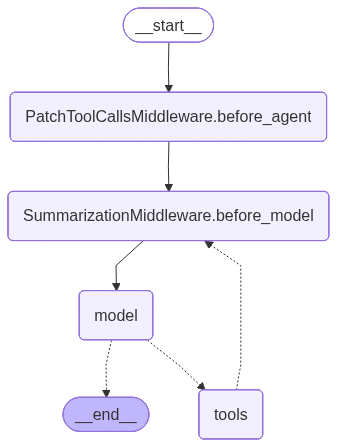

In [78]:
# File System Agent 생성
filesystem_agent_prompt = """당신은 로그 분석 전문가입니다.

## 역할
- 대용량 로그 데이터를 효율적으로 분석합니다
- 필요한 정보만 선택적으로 추출합니다

## File System 도구 활용
- fetch_large_logs로 얻은 데이터가 파일로 저장되면, read_file로 필요한 부분만 읽으세요
- grep 도구로 특정 패턴을 검색할 수 있습니다
- 전체 내용을 한 번에 읽으려 하지 마세요 (컨텍스트 낭비)

## 작업 흐름
1. fetch_large_logs로 로그 데이터 가져오기
2. 데이터가 파일로 저장되었는지 확인
3. grep이나 read_file로 필요한 부분만 읽기
4. 분석 결과 요약"""

filesystem_agent = create_deep_agent(
    model=llm,
    tools=[fetch_large_logs],
    system_prompt=filesystem_agent_prompt,
)
filesystem_agent

### 테스트: 대용량 데이터 자동 오프로딩


In [79]:
query = "최근 7일간 로그에서 ERROR 패턴을 찾아 요약해줘."

result = filesystem_agent.invoke({"messages": [HumanMessage(content=query)]})

print("-" * 70)
print(result["messages"][-1].content)
print("-" * 70)

print(f"   - 총 메시지 수: {len(result['messages'])}")

# 파일 저장 여부 확인
file_saved = False
for msg in result["messages"]:
    if hasattr(msg, "content") and isinstance(msg.content, str):
        if "/tmp/" in msg.content or "파일" in msg.content or "file" in msg.content.lower():
            file_saved = True
            print("   대용량 결과가 파일로 저장됨")
            break

if not file_saved:
    print("   파일 저장이 감지되지 않음 (데이터가 20K 토큰 미만일 수 있음)")

# 도구 사용 내역 확인
tool_calls = [msg for msg in result["messages"] if hasattr(msg, "tool_calls")]
print(
    f"   - 도구 호출 수: {sum(len(msg.tool_calls) for msg in tool_calls if hasattr(msg, 'tool_calls'))}"
)

# File System 도구 사용 확인
filesystem_tools_used = []
for msg in tool_calls:
    if hasattr(msg, "tool_calls"):
        for tc in msg.tool_calls:
            if tc["name"] in ["read_file", "write_file", "grep", "ls"]:
                filesystem_tools_used.append(tc["name"])

if filesystem_tools_used:
    print(f"   File System 도구 사용: {', '.join(set(filesystem_tools_used))}")
else:
    print("   File System 도구 미사용")


fetch_large_logs 실행: 7일치 로그 생성
   - 로그 항목 수: 20,160
   - 전체 크기: 2,330,494 chars
   - 예상 토큰: ~262,081 tokens
----------------------------------------------------------------------
최근 7일간의 로그 데이터에서 "ERROR" 패턴에 해당하는 로그가 발견되지 않았습니다. 요약할 오류 로그가 없습니다. 다른 검색어나 조건으로 추가 분석이 필요하면 말씀해주세요.
----------------------------------------------------------------------
   - 총 메시지 수: 6
   대용량 결과가 파일로 저장됨
   - 도구 호출 수: 2
   File System 도구 사용: grep


### 포인트

**자동 파일 저장**: 20K 토큰을 초과하는 도구 결과는 자동으로 파일로 저장됩니다.

**컨텍스트 참조**: 메시지에는 전체 데이터 대신 파일 경로만 남아 컨텍스트 창을 절약합니다.

**선택적 읽기**: Agent는 `read_file`이나 `grep`으로 필요한 부분만 읽어 효율적으로 작업합니다.

**토큰 절약**: 대용량 데이터를 직접 컨텍스트에 포함시키지 않아 토큰 비용이 크게 감소합니다.

### File System 도구 목록

| 도구 | 설명 | 사용 예시 |
|------|------|----------|
| `ls` | 디렉토리 내용 조회 | 작업 디렉토리 확인 |
| `read_file` | 파일 읽기 | 저장된 데이터 일부 읽기 |
| `write_file` | 파일 쓰기 | 중간 결과 저장 |
| `edit_file` | 파일 편집 | 기존 파일 수정 |
| `glob` | 패턴 매칭 파일 검색 | `*.log` 파일 찾기 |
| `grep` | 텍스트 패턴 검색 | 로그에서 ERROR 검색 |

---


## Human-in-the-Loop (HITL) - 민감 작업 승인

### 학습 목표
- Human-in-the-Loop 패턴 이해
- HumanInTheLoopMiddleware 의 `interrupt_on` 설정을 통한 작업 중단 및 승인 가능
- Checkpointer를 활용한 상태 저장 및 재개

### 핵심 인사이트
**"Human-in-the-Loop는 Agent가 위험한 작업(파일 삭제, 이메일 발송, 결제 처리 등)을 실행하기 전에 사람의 승인을 받도록 강제하는 안전 메커니즘입니다. Checkpointer가 필수이며, 중단된 시점부터 상태를 재개할 수 있습니다."**

### HITL이 필요한 작업

- 데이터 삭제 (파일, 데이터베이스 레코드)
- 외부 통신 (이메일, SMS, Slack 메시지)
- 금융 거래 (결제, 송금, 청구)


In [67]:
import uuid

from langgraph.checkpoint.memory import InMemorySaver


# 위험한 도구 정의
@tool
def delete_file_dangerous(path: str) -> str:
    """파일을 삭제합니다 (위험).

    Args:
        path: 삭제할 파일 경로

    Returns:
        삭제 결과 메시지
    """
    return f"파일 '{path}' 삭제됨"


@tool
def send_email_tool(to: str, subject: str, body: str) -> str:
    """이메일을 발송합니다 (민감).

    Args:
        to: 수신자 이메일
        subject: 제목
        body: 본문

    Returns:
        발송 결과 메시지
    """
    return f"이메일 발송됨: {to} - {subject}"


@tool
def restart_server_tool(server_name: str) -> str:
    """서버를 재시작합니다 (매우 위험).

    Args:
        server_name: 재시작할 서버 이름

    Returns:
        재시작 결과 메시지
    """
    return f"서버 '{server_name}' 재시작됨"


### HITL Agent 생성

`interrupt_on` 설정으로 특정 도구 실행 전 승인을 요구합니다.


### 테스트 1: 위험한 작업 실행 → 중단 확인


In [ ]:
import uuid

# HITL Agent 생성
hitl_agent_prompt = """당신은 시스템 관리자 어시스턴트입니다.

## 역할
- 사용자의 요청에 따라 시스템 관리 작업을 수행합니다
- 파일 삭제, 이메일 발송, 서버 재시작 등의 작업을 처리할 수 있습니다
"""
_checkpointer = MemorySaver()

# checkpointer와 thread_id를 전역으로 유지
if "_checkpointer" not in globals():
    _checkpointer = MemorySaver()
    thread_id = str(uuid.uuid4())
    print(f"새 세션 시작 - Thread ID: {thread_id}")
else:
    print("기존 세션 유지")

# 에이전트 생성
hitl_agent = create_deep_agent(
    model=llm,
    tools=[delete_file_dangerous, send_email_tool, restart_server_tool],
    system_prompt=hitl_agent_prompt,
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "delete_file_dangerous": {"allowed_decisions": ["approve", "edit", "reject"]},
                "send_email_tool": {"allowed_decisions": ["approve", "reject"]},
                "restart_server_tool": {"allowed_decisions": ["approve", "reject"]},
            }
        )
    ],
    checkpointer=_checkpointer,
)

기존 세션 유지


In [ ]:
config = RunnableConfig(configurable={"thread_id": thread_id})

result = hitl_agent.invoke(
    {"messages": [HumanMessage(content="old_data.txt 파일을 삭제해줘.")]},
    config=config,
)

# interrupt 정보 확인
if result.get("__interrupt__"):
    interrupts = result["__interrupt__"][0].value
    action_requests = interrupts["action_requests"]
    review_configs = interrupts["review_configs"]

    for action in action_requests:
        print(f"Tool: {action['name']}")
        print(f"Arguments: {action['args']}")


Tool: delete_file_dangerous
Arguments: {'path': '/old_data.txt'}


In [83]:
# 셀 3: 재개 실행 (decision 제공)
decisions = [{"type": "approve"}]

# 중요: hitl_agent를 사용하고, 같은 config를 전달
result = hitl_agent.invoke(  # agent가 아닌 hitl_agent
    Command(resume={"decisions": decisions}),
    config=config,  # 같은 thread_id 유지
)

# 최종 결과
print(result["messages"][-1].content)

old_data.txt 파일을 삭제했습니다. 추가로 필요한 작업이 있으면 말씀해 주세요.


### 포인트

**자동 중단**: `interrupt_on`에 지정된 도구 호출 시 자동으로 실행이 중단됩니다.

**상태 저장**: Checkpointer가 중단 시점의 상태를 저장하여, 승인/거부 후 정확히 그 시점부터 재개할 수 있습니다.

**승인/거부 처리**: `update_state`로 "approve" 또는 "reject"를 전달하여 작업 재개 또는 중단을 제어합니다.

**Thread 격리**: 각 대화 스레드는 독립적으로 관리되며, `thread_id`로 구분됩니다.

### HITL 워크플로우

```
1. Agent가 위험한 도구 호출 시도
   ↓
2. interrupt_on 설정에 의해 실행 중단
   ↓
3. __interrupt__ 플래그가 result에 포함됨
   ↓
4. 사람이 승인 여부 결정 (approve/reject)
   ↓
5. update_state로 결정 전달
   ↓
6. Agent 재실행 (invoke with None)
   ↓
7. 승인: 도구 실행 계속
   거부: 작업 중단, 사용자에게 알림
```

### 추가 옵션

HumanInTheLoopMiddleware 의 `interrupt_on`은 더 세밀한 제어도 지원합니다:

```python
interrupt_on = {
    "send_email_tool": {
        "allowed_decisions": ["approve", "reject", "edit"],
        "message": "이메일 발송 전 검토가 필요합니다.",
    }
}
```

- **allowed_decisions**: 허용된 결정 목록
- **message**: 승인 요청 시 표시할 메시지
- **edit**: 도구 파라미터 수정 후 실행 가능



### 참고 자료

- **Claude Skills**: https://claude.com/blog/skills, https://github.com/anthropics/skills
- **Agent 2.0 Paradigm**: https://www.philschmid.de/agents-2.0-deep-agents
- **DeepAgents**: https://github.com/langchain-ai/deepagents, https://docs.langchain.com/oss/python/deepagents/
- **LangGraph**: https://docs.langchain.com/oss/python/langgraph/


---

### TODO: 여러분이 직접 DeepAgent 를 통해 Dynamic Allocation 가능한 Agentic System 을 만들어 볼 시간입니다.
> Claude Skills 에 대한 탐구를 더 깊이 진행해볼까요?

In [ ]:
## 설계

## 구현 방안
